In [27]:
import os
import glob

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
%matplotlib inline



In [23]:
cwd = os.getcwd()
plot_dir = os.path.join(cwd, 'plots')
sns.set_theme(style="whitegrid")

# Technical Approach
## a) Bayesian Estimation
Consider the training set D1 and strategy 1,

 For each class, compute the covariance $\Sigma$ of the class-conditional, and the posterior mean $\mu_1$ , and covariance $\Sigma_1$ of

 $$ P_{\mu|T}(\mu|D1) = N (\mu, \mu1, \Sigma_1) $$

$$ p(x|\mu) \sim N(\mu, \Sigma) $$
$$ p(\mu) \sim N (\mu_0, \Sigma_0) $$
where $\Sigma$, $\Sigma_0$ and $\mu_0$ are assumed to be known.

We cheat a little bit by simply replacing the true covariance matrix by the sample covariance of the training set D.
$$ \Sigma = \hat{\Sigma} = \frac{1}{N}\sum_{k=1}^{n} \Big(x_k - \frac{1}{N} \sum_{i = 1}^{N} x_i\Big) \Big(x_k - \frac{1}{N} \sum_{i = 1}^{N} x_i\Big)^T $$

For the covariance of gaussian prior $\Sigma_0$, we assume a diagonal matrix with $$(\Sigma_0)_{ii} = \alpha \omega_i$$

------------------------------------------------------------------------------

$$\mu_n = \Sigma_{0} \big(\Sigma_{0} + \frac{1}{n}\Sigma\big)^{-1} \hat{\mu_{n}} + \frac{1}{n}\Sigma \big(\Sigma_0 + \frac{1}{n}\Sigma \big)^{-1} \mu_{0}$$

Where $\hat{\mu_{n}}$ is the sample mean
$$\hat{\mu_n} = \frac{1}{n} \sum_{k=1}^{n} x_k$$

$$ \Sigma_{n}^{-1} = n \Sigma^{-1} + \Sigma_{0}^{-1} $$
$$ \Longrightarrow \Sigma_n = \Sigma_0 \big(\Sigma_0 + \frac{1}{n}\Sigma \big)^{-1} \frac{1}{n}\Sigma$$ 


Since the sum of two independent, normally distibuted vectors is again a normally distributed vector. 

whose mean is the sum of the means 

and whose covariance matrixis is the sum of the covariance matrices
$$ p(x|D) \sim N(\mu_n, \Sigma + \Sigma_n) $$

We can compute the predictive distribution and plug into the BDR.

## b) MLE
This part is same as what we do in the previous homework.

### ML-BDR:
pick i if 
$$ i^{*} = \argmax_{i} P_{X|Y}(x|i;\theta_{i}^{*})P_Y(i)$$

where $$\theta_{i}^{*} = \argmax_{\theta} P_{X|Y}(D|i,\theta)$$

In the gaussian case, we obtain the posterior mean and covariance matrix as sample mean and sample covariance.

$$ \mu = \hat{\mu} = \frac{1}{n} \sum_{k=1}^{n} x_k $$
$$ \Sigma = \frac{1}{N}\sum_{k=1}^{n} \Big(x_k - \mu\Big) \Big(x_k - \mu\Big)^T $$

## c) MAP estimate of $\mu$

$$ P_{X|T}(x|D1) = P_{X|\mu}(x|\mu_{MAP})$$

where
$$ \mu_{MAP} = \argmax_{\mu} P_{\mu|T}(\mu|D1) \\ = \argmax_{\theta} P_{T|\mu}(D1|\mu)P_{\Theta}(\theta)$$

and corresponds to approximating the prior by a delta function centered at its maximum.

In this case, we have
$$ \mu_{MAP} = \Sigma_{0} \big(\Sigma_{0} + \frac{1}{n}\Sigma\big)^{-1} \hat{\mu_{n}} + \frac{1}{n}\Sigma \big(\Sigma_0 + \frac{1}{n}\Sigma \big)^{-1} \mu_{0} \\ =\mu_n $$

$$ \Sigma_{MAP} = \Sigma = \hat{\Sigma}$$

The difference between ML and Bayes MAP is non-negligible only when the dataset is small.


In [29]:
data = {
    'D1': [75 ,300],
    'D2': [125,500],
    'D3': [175,700],
    'D4': [225,900],
    }
df = pd.DataFrame.from_dict(data, orient='index', columns=['FG', 'BG'])
df.head()

,FG,BG
D1,75,300
D2,125,500
D3,175,700
D4,225,900


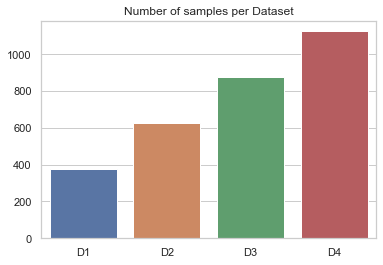

In [31]:

ax = sns.barplot(x=["D1", "D2", "D3", "D4", ], y=[sum(data['D1']), sum(data['D2']), sum(data['D3']), sum(data['D4'])])
plt.title("Number of samples per Dataset")
plt.show()

# Discussion
## Strategy 1: 
$\mu_0$ is smaller for the (darker) cheetah class ($\mu_0$ = 1) and larger for the (lighter) grass class ($\mu_0$ = 3).

### Bayesian Estimation
Since strategy 1 is using a godd prior. we can see when $\alpha$ is small, the error is small as well. This can be confirm through all dataset's training result of strategy 1.

 $\alpha$ controls the variance of gaussian prior. when the variance is small ($\alpha$ is small), we are very certain that assumption prior close to true prior of parameter. Increasing the size of data will have a smaller effect on the result, because we rely more on the prior belief of parameter.

On the other hand, when $\alpha$ is large, we are uncertain about the prior of parameter. In this case, we will rely more on the data. As the size of data increases, the results is approching to the ML result, but it does not guarante to converge to the ML result.

### MLE
The MLE error is a horiziontal line since it use a determerministic parameter as opposed to Bayesian estimation method which use a stochastic parameter. The MLE is more accurate as the size of data increase, since the estimator $\hat{\mu}$ and $\hat{\Sigma}$ converge asymptotically to true mean and covariance.

### Bayes MAP Approximation
The MAP error curve starts at lower error. We can see it start very close to Bayesian estimation results since it is picking one model with largest probability instead of a weighted sum of every model. Then it increases as uncertantiy ($\alpha$) increase and eventually becomes a horizontal curve and converge to ML error. 

The difference between ML and Bayes MAP is non-negligible only when the dataset is small.

As $\alpha$ increase, the prior information has less effect on $\mu_{MAP}$, the $\mu_{MAP}$ nearly equals to the $\mu_{ML}$ over the sample data.

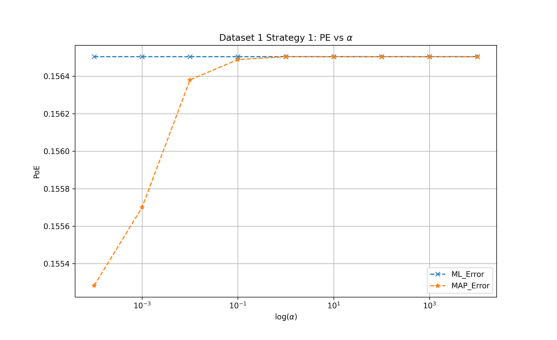

In [34]:
# Strategy 1:
'''Zoom in for D1 Strategy 1 with ML and MAP only'''
plt.figure(figsize=(12,6))
img = mpimg.imread(plot_dir + "/only.png")
plt.imshow(img)
plt.axis('off')
plt.show()


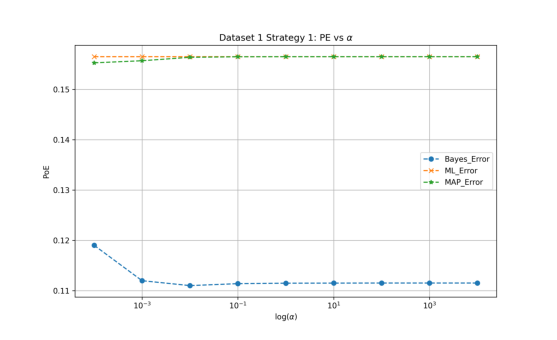

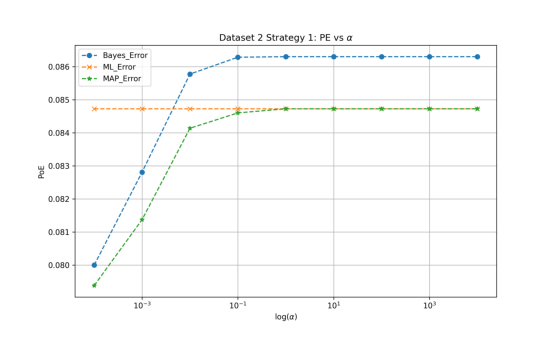

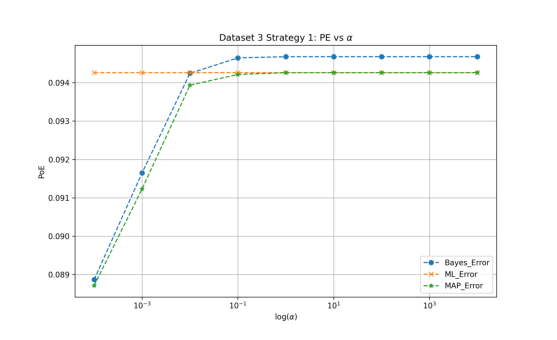

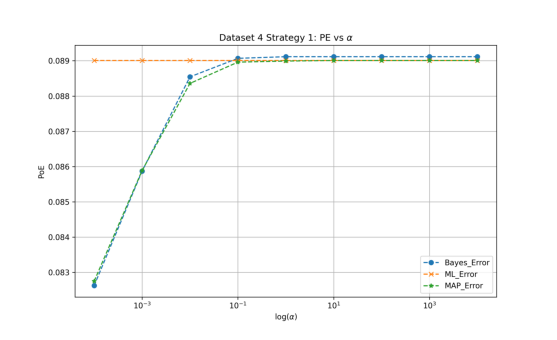

In [35]:
for fig in sorted(glob.glob(plot_dir + "/*Strategy 1.png")):
    plt.figure(figsize=(12,6))
    img = mpimg.imread(fig)
    plt.imshow(img)
    plt.axis('off')
    plt.show()

## Strategy 2:
$\mu_0$ is equal to half the range of amplitudes of the DCT coefficient for both classes ($\mu_0$ = 2)
This time our prior is not good.


### Bayesian Estimation
All implementation logic is the same as strategy 1. We can see now our prior is not as good as the one in stragegy 1. As the vairance of prior increase, the Bayesian estiamtion rely more on data which act as a heuristic to correct our biased prior assumption.

### MLE
The trend of MLE error is not affect by the strategy but since the parameter is deterministic. The MLE is more accurate as the size of data increase, since the estimator $\hat{\mu}$ and $\hat{\Sigma}$ converge asymptotically to true mean and covariance.

### Bayes MAP Approximation

Form D1, we see a huge gap between Bayesian estimation and Bayes MAP. Since we are picking only one model with maximum posterior to approximate the Bayesian estimiation. All other information except the MAP one is lost.

The difference between ML and Bayes MAP is non-negligible only when the dataset is small.

As mentioned above, Bayes MAP error will eventually converge to ML error when the dataset is large and variance of prior is also large.



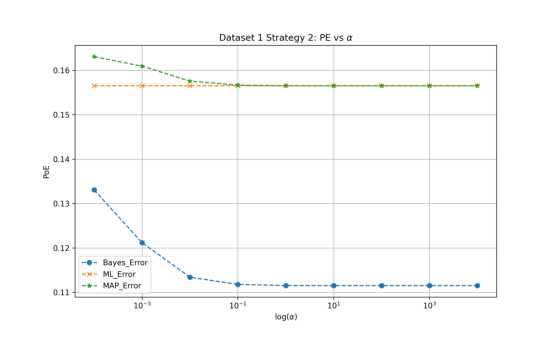

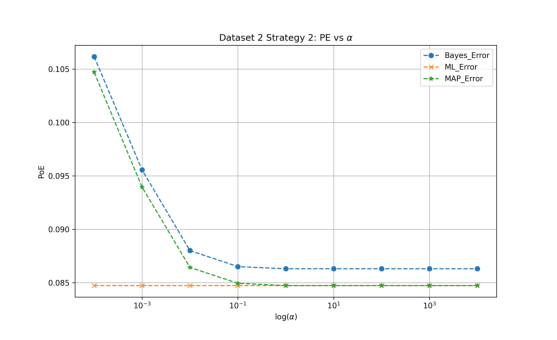

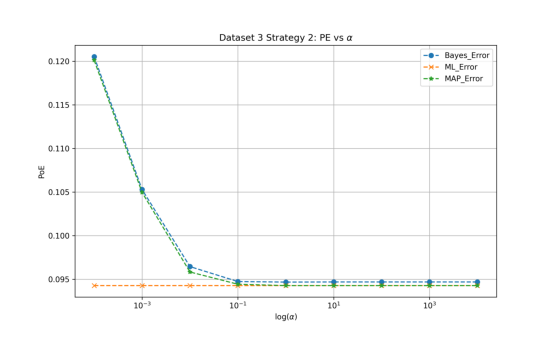

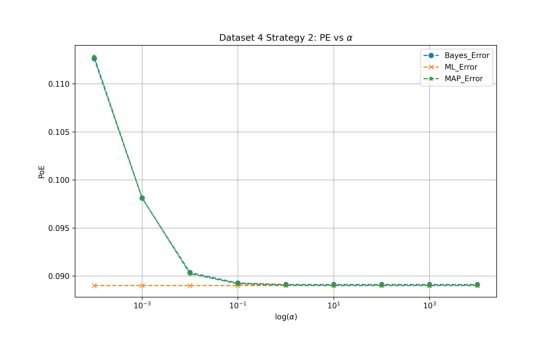

In [18]:
# Strategy 2:
for fig in sorted(glob.glob(plot_dir + "/*Strategy 2.png")):
    plt.figure(figsize=(12,6))
    img = mpimg.imread(fig)
    plt.imshow(img)
    plt.axis('off')
    plt.show()